In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from six.moves import cPickle

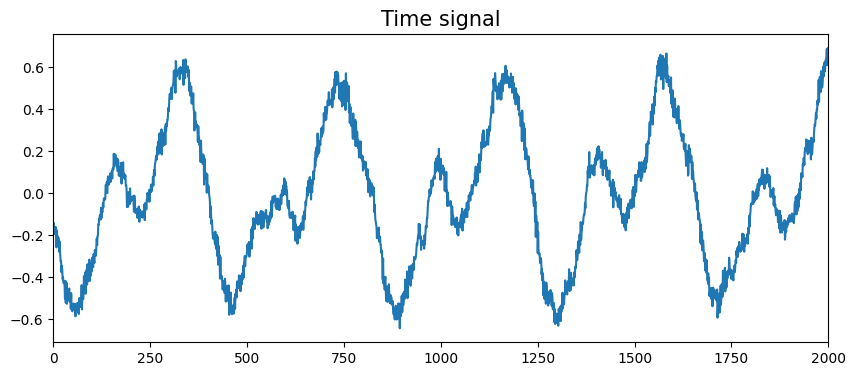

In [4]:
data = cPickle.load(open('/content/gdrive/MyDrive/Data/rnn_time_signal.pkl', 'rb'))

plt.figure(figsize = (10, 4))
plt.title('Time signal', fontsize=15)
plt.plot(data[0:2000])    ## 실제 80000 길이의 데이터
plt.xlim(0,2000)
plt.show()

In [ ]:
n_step = 25
n_input = 100

# LSTM shape
n_lstm1 = 100
n_lstm2 = 100

# fully connected
n_hidden = 100
n_output = 100

In [ ]:
lstm_network = tf.keras.models.Sequential([
    tf.keras.layers.Input((n_step, n_input)),
    tf.keras.layers.LSTM(n_lstm1, return_sequences = True),
    tf.keras.layers.LSTM(n_lstm2),
    tf.keras.layers.Dense(n_hidden, activation = 'relu'),
    tf.keras.layers.Dense(n_output)
])

lstm_network.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 25, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        10,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 181,000 (707.03 KB)

 Trainable params: 181,000 (707.03 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
lstm_network.compile(optimizer = 'adam',
                    loss = 'mean_squared_error',
                    metrics = ['mse'])

In [ ]:
def dataset(data, n_samples, n_step = n_step, dim_input = n_input, dim_output = n_output, stride = 5):

    train_x_list = []
    train_y_list = []

    for i in range(n_samples):
        train_x = data[i*stride:i*stride + n_step*dim_input]
        train_x = train_x.reshape(n_step, dim_input)
        train_x_list.append(train_x)

        train_y = data[i*stride + n_step*dim_input:i*stride + n_step*dim_input + dim_output]
        train_y_list.append(train_y)

    train_data = np.array(train_x_list)
    train_label = np.array(train_y_list)

    test_data = data[10000:10000 + n_step*dim_input]
    test_data = test_data.reshape(1, n_step, dim_input)

    return train_data, train_label, test_data

In [ ]:
train_data, train_label, test_data = dataset(data, 5000)

In [ ]:
test_data.shape

(1, 25, 100)

In [ ]:
lstm_network.fit(train_data, train_label, epochs = 3)

Epoch 1/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0047 - mse: 0.0047
Epoch 2/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0044 - mse: 0.0044
Epoch 3/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0044 - mse: 0.0044


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


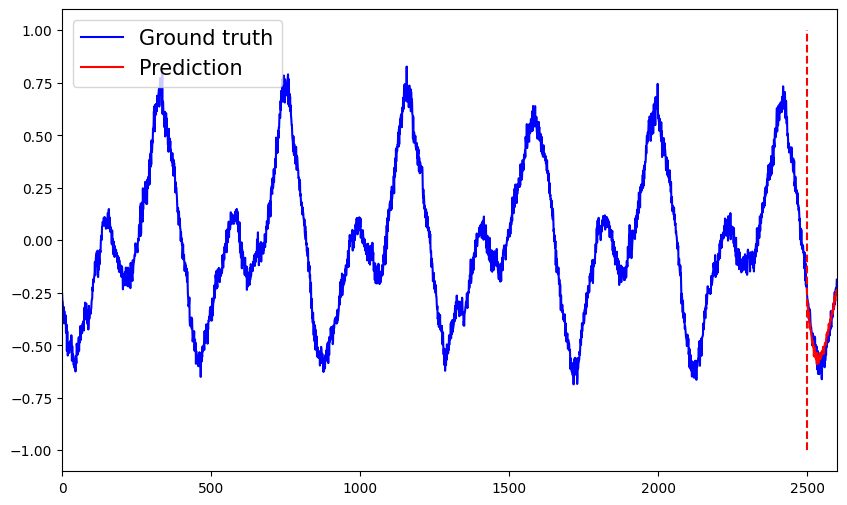

In [ ]:
test_pred = lstm_network.predict(test_data).reshape(-1)
test_label = data[10000:10000 + n_step*n_input + n_input]

plt.figure(figsize=(10,6))
plt.plot(np.arange(0, n_step*n_input + n_input), test_label, 'b', label = 'Ground truth')
plt.plot(np.arange(n_step*n_input, n_step*n_input + n_input), test_pred, 'r', label = 'Prediction')
plt.vlines(n_step*n_input, -1, 1, colors = 'r', linestyles = 'dashed')
plt.legend(fontsize = 15, loc = 'upper left')
plt.xlim(0, len(test_label))
plt.show()

In [ ]:
test_step = 50

(1, 100)
(1, 1, 100)


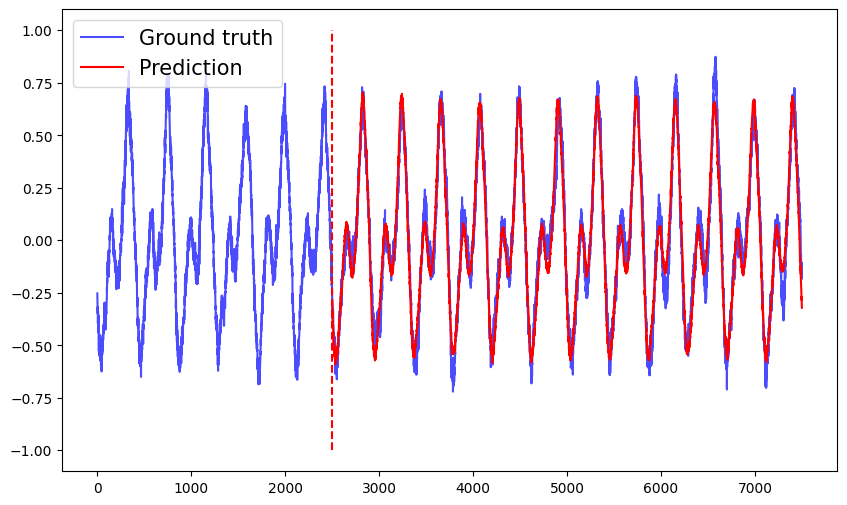

In [ ]:
test_data_ = test_data.copy()
gen_signal = []

for i in range(test_step):
    test_pred = lstm_network.predict(test_data_, verbose = 0)
    if i == 0:
        print(test_pred.shape)
    gen_signal.append(test_pred.reshape(-1))
    test_pred = test_pred[:, np.newaxis, :]
    if i == 0:
        print(test_pred.shape)
    test_data_ = test_data_[:, 1:, :]
    test_data_ = np.concatenate([test_data_, test_pred], axis = 1)

gen_signal = np.concatenate(gen_signal)

test_label = data[10000:10000 + n_step*n_input + test_step*n_input]

plt.figure(figsize=(10,6))
plt.plot(np.arange(0, n_step*n_input + test_step*n_input), test_label, 'b', alpha=0.7, label = 'Ground truth')
plt.plot(np.arange(n_step*n_input,  n_step*n_input + test_step*n_input), gen_signal, 'r', label = 'Prediction')
plt.vlines(n_step*n_input, -1, 1, colors = 'r', linestyles = 'dashed')
plt.legend(fontsize=15, loc = 'upper left')
# plt.xlim(0, len(test_label))
plt.show()